# Models

In [1]:
%load_ext autoreload
%autoreload 2

In [109]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import data as dt
import data.plot as pl

import model as ml

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import data.plot as pl

import logging

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
device_name = 'gpu'

pu.set_device_name(device_name)
pu.set_device_memory(device_name, process_memory_fraction=0.5)

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

## Carga de dataset

1. importamos los archivos de peliculas y ratings preprocesados prebiamente en mongodb:

In [8]:
DATASETS_PATH   = '../datasets'

movies          = pd.read_json(f'{DATASETS_PATH}/movies.json')
interactions    = pd.read_json(f'{DATASETS_PATH}/interactions.json')

In [9]:
len(interactions)

210725

In [10]:
import time

import numpy as np
import torch
from matplotlib import pyplot as plt

from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [11]:
interactions['user_seq'] =  interactions.user_id.apply(dt.Sequencer().get)
interactions['movie_seq'] =  interactions.movie_id.apply(dt.Sequencer().get)

interactions[['user_seq', 'user_id']].to_json(f'{DATASETS_PATH}/user_seq_id.json')
interactions[['movie_seq', 'movie_id']].to_json(f'{DATASETS_PATH}/movie_seq_id.json')

In [12]:
rm = dt.RatingsMatrix.from_dataframe(interactions, 'user_seq', 'movie_seq', 'rating')
rm.shape

2022-04-27 21:42:50,495 - INFO - Create ratting matrix - computing time: 0:00:09.12


(13281, 22082)

<Figure size 720x432 with 2 Axes>

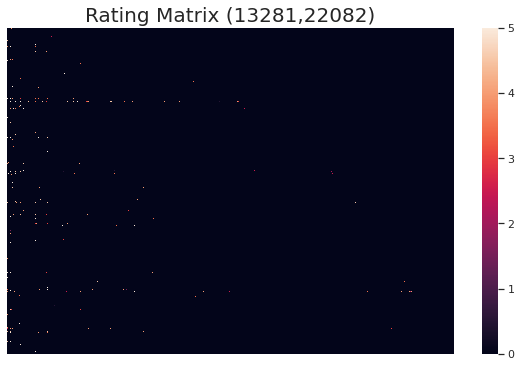

In [13]:
rm.plot()

In [116]:
predictor = ml.KNNUserBasedPredictor(rm, ml.CosineDistance())

2022-04-27 23:00:05,679 - INFO - distances matrix - computing time: 0:03:04.05


In [118]:
def batch_sample(interactions, batch_size):
    indexes = torch.randint(0, interactions.shape[0]-1, (batch_size,))
    
    features_batch = interactions[['user_seq', 'movie_seq']].iloc[indexes, :].values
    label_batch    = interactions[['rating']].iloc[indexes, :].values.reshape((-1,))

    return features_batch, label_batch

In [138]:
n_samples   = 200
n_neighbors = 5000
batch_size  = 10

metrics_log = []
for sample in range(n_samples):
    x_batch, y_batch = batch_sample(interactions, batch_size)

    summary = predictor.evaluate(
        x_batch,
        y_batch,
        n_neighbors,
        metrics_fn = {
            'mse': mean_squared_error,
            'mae': mean_absolute_error
        }
    )
    summary['sample'] = sample

    logging.info(summary)
    metrics_log.append(summary)

2022-04-27 23:28:22,986 - INFO - computing time: 0:00:01.24
2022-04-27 23:28:22,987 - INFO - {'mse': 0.38742273129800536, 'mae': 0.5232496976852417, 'sample': 0}
2022-04-27 23:28:24,382 - INFO - computing time: 0:00:01.39
2022-04-27 23:28:24,383 - INFO - {'mse': 0.3463905384086729, 'mae': 0.495026159286499, 'sample': 1}
2022-04-27 23:28:25,594 - INFO - computing time: 0:00:01.21
2022-04-27 23:28:25,595 - INFO - {'mse': 1.0851305887514229, 'mae': 0.8668308973312377, 'sample': 2}
2022-04-27 23:28:26,987 - INFO - computing time: 0:00:01.39
2022-04-27 23:28:26,988 - INFO - {'mse': 0.6619373918812699, 'mae': 0.6591284275054932, 'sample': 3}
2022-04-27 23:28:28,178 - INFO - computing time: 0:00:01.19
2022-04-27 23:28:28,178 - INFO - {'mse': 3.1985762753448284, 'mae': 1.3117053031921386, 'sample': 4}
2022-04-27 23:28:29,592 - INFO - computing time: 0:00:01.41
2022-04-27 23:28:29,593 - INFO - {'mse': 0.3889406208611888, 'mae': 0.5011958360671998, 'sample': 5}
2022-04-27 23:28:30,826 - INFO - c


Range: (0.1845263175238813, 4.85601137361777)



<Figure size 1080x288 with 2 Axes>

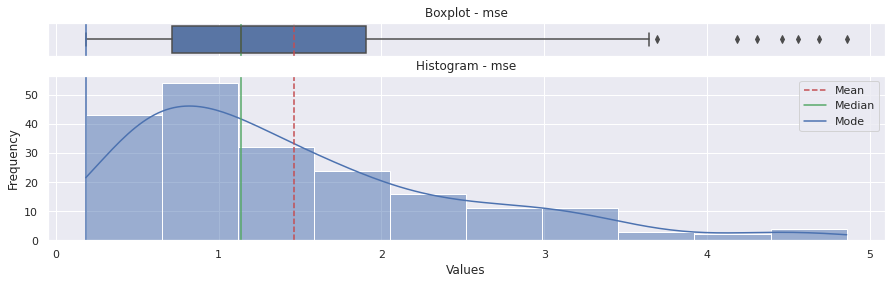


Metrics:



,mse
count,200.000000
mean,1.460437
std,0.998643
min,0.184526
25%,0.711357
50%,1.135464
75%,1.902138
max,4.856011



Range: (0.3334479570388794, 1.6184411287307738)



<Figure size 1080x288 with 2 Axes>

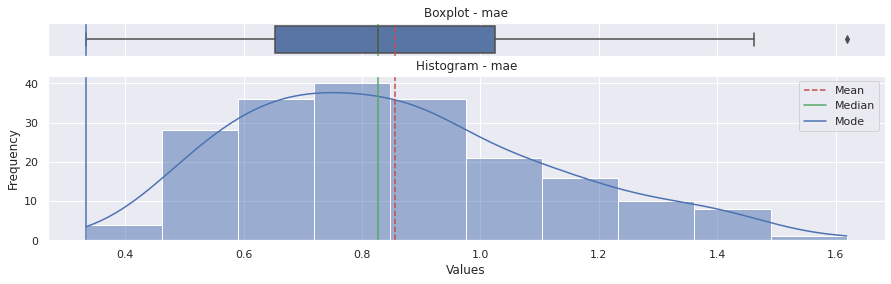


Metrics:



,mae
count,200.000000
mean,0.855318
std,0.258398
min,0.333448
25%,0.652438
50%,0.827097
75%,1.024749
max,1.618441


In [139]:
metrics = pd.DataFrame(metrics_log)

for name in metrics.columns[:2]:
    pl.l_flat_size()
    pl.describe_num_var(metrics, name, bins=10)